In [1]:
import tensorflow as tf


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt



In [4]:
from sklearn.utils import shuffle

import tensorflow as tensorflow
from keras.models import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, Flatten, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from keras.engine.topology import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [5]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
PATH = os.chdir('C:\\Users\\draam\\Jupyter_drive\\rsna-pneumonia-detection-challenge')

In [7]:
pwd

'C:\\Users\\draam\\Jupyter_drive\\rsna-pneumonia-detection-challenge'

# Load nodule locations
* Table contains [filename : nodule location] pairs per row.

* If a filename contains multiple nodules, the table contains multiple rows with the same filename but different nodule locations.
* If a filename contains no nodules it contains a single row with an empty nodule location.
* The code below loads the table and transforms it into a dictionary.

* The dictionary uses the filename as key and a list of nodule locations in that filename as value.
* If a filename is not present in the dictionary it means that it contains no nodules.

In [8]:
# empty dictionary
nodule_locations = {}
# load table
with open(os.path.join('../stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        nodule = rows[5]
        # if row contains a nodule add label to dictionary
        # which contains a list of nodule locations per filename
        if nodule == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save nodule location in dictionary
            if filename in nodule_locations:
                nodule_locations[filename].append(location)
            else:
                nodule_locations[filename] = [location]

# Load filenames

In [9]:
folder = '../stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560


# Exploration

Total train images: 26684
Images with nodule: 6012


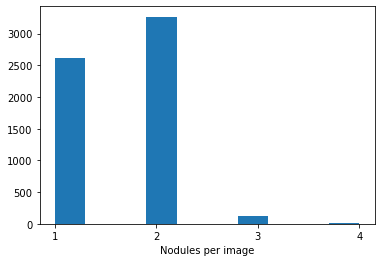

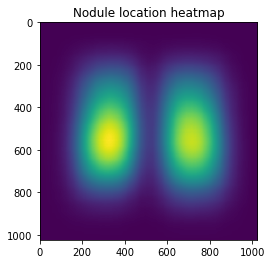

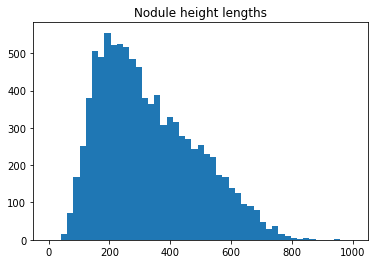

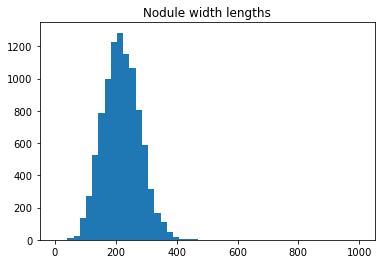

Minimum nodule height: 45
Minimum nodule width:  40


In [10]:
print('Total train images:',len(filenames))
print('Images with nodule:', len(nodule_locations))

ns = [len(value) for value in nodule_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Nodules per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in nodule_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Nodule location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Nodule height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Nodule width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum nodule height:', np.min(hs))
print('Minimum nodule width: ', np.min(ws))

[257.49316239 503.81396011]
[195.81356493 227.92142266]


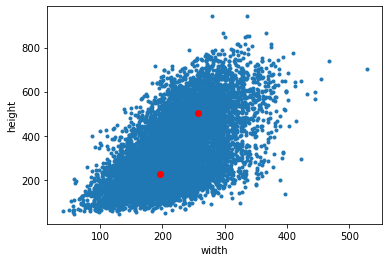

In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(np.array([ws, hs]).T)
centers = kmeans.cluster_centers_
plt.figure()
plt.scatter(ws, hs, marker='.')
plt.xlabel('width')
plt.ylabel('height')
for center in centers:
    print(center)
    plt.scatter(center[0], center[1], c='red')
plt.show()

# Data generator
** The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.

In [12]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, nodule_locations=None, batch_size=32, image_size=256, shuffle=True, predict=False, augment = False):
        self.folder = folder
        self.filenames = filenames
        self.nodule_locations = nodule_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.shuffle = shuffle
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains nodules
        if filename in nodule_locations:
            # loop through nodules
            for location in nodule_locations[filename]:
                # add 1's at the location of the nodule
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

# Network
## BatchNormormalization: Fine-Tune your Booster
### Batch Normalization is work like normalize the sample data so we can train for better accuracy and result. It is same like we can do in Machine learning.
* We can even apply this normalization to the input of neural networks. It fastens up training as in linear regression. 
* But since the 2nd layer changes this distribution

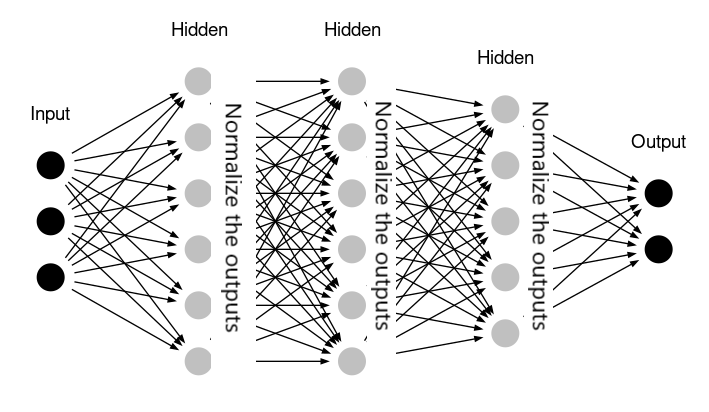

* Due to this normalization “layers” between each fully connected layers, the range of input distribution of each layer stays the same, no matter the changes in the previous layer.
* Given x inputs from k-th neuron.

* Normalization brings all the inputs centered around 0. This way, there is not much change in each layer input. 
* So, layers in the network can learn from the back-propagation simultaneously, without waiting for the previous layer to learn. 
* This fastens up the training of networks.



* We apply Batch Normalization to the best-performing ImageNet classification network, and show that we can match its performance using only 7% of the training steps, and can further exceed its accuracy by a substantial margin. * * — Original BatchNorm Paper

*  But, sometimes, it is difficult to keep track of all the mini-batch mean and variances. 
* In such cases, exponential weighted “moving average” can be used to update population mean and variance:

**Momentum**

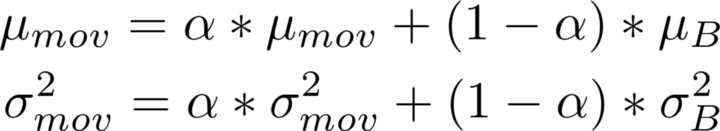

**Here, α is the momentum, γ = σ and β = mean**
* Momentum is the importance given to the previous moving average, when calculating the population average for inference. If you can’t understand what momentum is, It’s nothing but the smoothing that we can adjust in Tensorboard. Momentum is the “lag” in learning mean and variance, so that noise due to mini-batch can be ignored.

**Actual(light) and lagged(bold) values with momentum 0.99 and 0.75**

**By default, momentum would be set a high value about 0.99**, meaning high lag and slow learning. When batch sizes are small, the no. of steps run will be more. So high momentum will result in slow but steady learning (more lag) of the moving mean. So, in this case, it is helpful.
*But when the batch size is bigger, as I have used, i.e 5K images (out of 50K) in single step, the number of steps is less. Also, the statistics of mini-batch are mostly same as that of the population. At these times, momentum has to be less, so that the mean and variance are updated quickly. Hence a ground rule is that:
* **Small batch size => High Momentum (0.9–0.99)**
* **Big batch size => Low Momentum (0.6–0.85)**

#### **Calculation of moving mean and variance**

* Here α is the **“momentum” given to previous moving statistic, around 0.9.** And those with **B subscript are mini-batch mean and mini-batch variance**. This is the implementation found in most libraries, where the momentum can be set manually.
* An important thing to note here is that the **moving mean and moving variance** are calculated at training time, with training dataset and not at testing time.

In [13]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=5):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=5):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Train network

In [15]:
import multiprocessing
from multiprocessing import Pool



In [16]:
# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=128, channels=16, n_blocks=2, depth=4)
model.compile(optimizer=keras.optimizers.Adam(lr=.01),loss=keras.losses.binary_crossentropy,metrics=['accuracy', mean_iou])


multiprocessing.set_start_method('spawn', force=True)

# create train and validation generators
folder = '../stage_2_train_images'
train_gen = generator(folder, train_filenames, nodule_locations, batch_size=32, image_size=128, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, nodule_locations, batch_size=32, image_size=128, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, epochs=4, shuffle=True, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 753 steps, validate for 80 steps
Epoch 1/4
753/753 [==============================] - 2320s 3s/step - loss: 0.0976 - accuracy: 0.9725 - mean_iou: 0.7725 - val_loss: 0.3129 - val_accuracy: 0.9737 - val_mean_iou: 0.7717
Epoch 2/4
753/753 [==============================] - 2298s 3s/step - loss: 0.0821 - accuracy: 0.9737 - mean_iou: 0.7703 - val_loss: 0.1153 - val_accuracy: 0.9737 - val_mean_iou: 0.7717
Epoch 3/4
753/753 [==============================] - 2285s 3s/step - loss: 0.0775 - accuracy: 0.9741 - mean_iou: 0.7661 - val_loss: 0.0824 - val_accuracy: 0.9740 - val_mean_iou: 0.7694
Epoch 4/4
753/753 [==============================] - 2281s 3s/step - loss: 0.0748 - accuracy: 0.9743 - mean_iou: 0.7664 - val_loss: 0.0831 - val_accuracy: 0.9744 - val_mean_iou: 0.7707


In [17]:
model.save("model.h5")

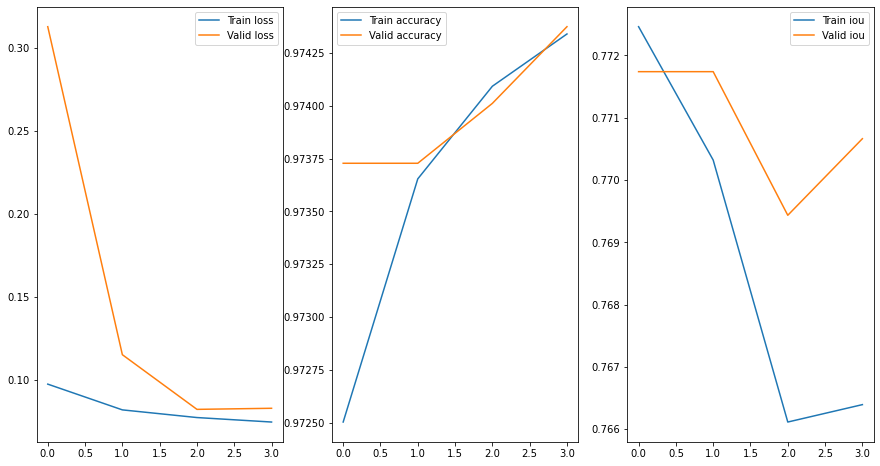

In [29]:
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

# Predict Test Images

In [21]:
# load and shuffle filenames
folder = '../stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=128, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission1.csv')

n test samples: 3000
